In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.nn.init import kaiming_uniform_
from torch.distributions import Normal
from scipy.ndimage.filters import uniform_filter1d
from matplotlib import pyplot as plt
from collections import namedtuple

In [2]:
import numpy as np
import gym
from tqdm import tqdm
import random as rand
from itertools import count
import time
import gym

In [3]:
class ReplayMemory():
    def __init__(self,capacity):   
        self.capacity = capacity
        self.memory = {}
        self.push_count = 0
        
    def push(self, timestep, experience):
        if len(self.memory) < self.capacity:
            self.memory[timestep] = experience
        else:
            del_key = None
            for k in self.memory.keys():
                del_key = k
                break
            self.memory.pop(del_key, None)
            self.memory[timestep] = experience
        self.push_count+=1
    
    def sample(self, batch_size):
        batch_tuple = random.sample(self.memory.items(), batch_size)#key(timestep), experiences
        experience_array = []
        for timestep, experiences in batch_tuple:
            experience_array.append(experiences)
        return experience_array
    
    def can_provide_sample(self, batch_size):
        return len(self.memory)>=batch_size
    
    def update_td_error(self, sampled_experiences, timesteps):
        for i in range(len(timesteps)):
            self.memory[timesteps[i]] = sampled_experiences[i]
        
    def get_memory_values(self):
        return self.memory 

In [4]:
class Agent():
    def __init__(self, env, ReplayMemory, online_policy, online_q_a, online_q_b,\
                online_policy_optimizer,online_q_network_optimizer_a, online_q_network_optimizer_b, target_q_a,\
                target_q_b, gamma=0.99, alpha_pr=0.4, beta_pr=0.3,\
                tau=0.01, n_ep=120, max_steps=100000, memory_size=1000000, batch_size=50,\
                policy_update_step=2, target_update=50, min_sample_size=500, warm_up=2):
        
        
        self.env = env
        self.tau = tau
        self.gamma = gamma
        self.alpha_pr = alpha_pr
        self.beta_pr = beta_pr
        self.agent_max_memory=memory_size
        self.batch_size = batch_size
        self.n_ep = n_ep
        self.max_steps = max_steps
        self.min_sample_size=min_sample_size
        self.target_update=target_update
        self.policy_update_step=policy_update_step
        self.online_policy_network = online_policy
        self.online_policy_optimizer = online_policy_optimizer
        self.online_q_network_a = online_q_a
        self.online_q_network_optimizer_a = online_q_network_optimizer_a
        self.online_q_network_b = online_q_b
        self.online_q_network_optimizer_b = online_q_network_optimizer_b
        self.target_q_network_a = target_q_a
        self.target_q_network_b = target_q_b
        self.current_timestep = 0
        self.warm_up = warm_up
        self.agent_memory = ReplayMemory(self.agent_max_memory)
        self.device = torch.device("cuda" if torch.cuda.is_available()\
                        else "cpu")
        self.Xp = namedtuple('Experience',
                        ('state', 'action', 'next_state', 'reward', 'done', 'abs_td_error','timestep'))
        
    def extract_tensors(self, experiences):
        batch = self.Xp(*zip(*experiences))
        state = np.stack(batch.state) #stack
        action = np.stack(batch.action)
        next_state = np.stack(batch.next_state)
        reward = np.stack(batch.reward)
        done = np.stack(batch.done)
        abs_td_error = np.stack(batch.abs_td_error)
        timestep = np.stack(batch.timestep)
        return state,action,next_state,reward,done,abs_td_error,timestep
    
    def rebuild_experiences(self, state, action, next_state, reward, done, abs_error, timestep):
        exp_list = []
        for idx_ in range(len(state)):
            exp_list.append(\
                        self.Xp(state[idx_], action[idx_], next_state[idx_], reward[idx_],\
                           done[idx_], abs_error[idx_], timestep[idx_]))
        return exp_list 
    
    def prioritize_samples(self, experience_samples, alpha, beta):
        state,action,next_state,reward,done,abs_td_error,timesteps \
                            = self.extract_tensors(experience_samples)
        abs_td_error, indices_ = (list(t) for t in zip(*sorted(\
                            zip(abs_td_error.tolist(), timesteps))))
        abs_td_error.reverse()
        indices_.reverse()#reverse to march sort func
        abs_td_error = np.array(abs_td_error)
        abs_td_error  = torch.tensor(abs_td_error)
        ranks = np.arange(1, len(abs_td_error)+1)
        priorities = 1.0/ranks
        priorities = priorities**alpha
        priorities = np.expand_dims(priorities, axis=1)
        probabilities = priorities/np.sum(priorities, axis=0)
        assert np.isclose(probabilities.sum(), 1.0)
        number_of_samples  = len(probabilities)
        weight_importance_ = number_of_samples*probabilities
        weight_importance_ = weight_importance_**-beta
        weight_importance_max = np.max(weight_importance_)
        weight_importance_scaled = weight_importance_/weight_importance_max
        return weight_importance_scaled, indices_ 
    
    def update_model(self, experience_samples,\
                weighted_importance, timestep_indices):
        
        states, actions, next_states, rewards, done, _ , timesteps =\
                    self.extract_tensors(experience_samples)
         
        arrange_weighted_values = [timestep_indices.index(i) for i in timesteps]
    
        states = torch.tensor(np.squeeze(states)).float().to(self.device)
        next_states = torch.tensor(np.squeeze(next_states)).float().to(self.device)
        actions = torch.tensor(actions).float().to(self.device)
        rewards = torch.tensor(rewards).unsqueeze(1).float().to(self.device)
        done = torch.tensor(done).unsqueeze(1).float().to(self.device)
        weighted_importance = torch.tensor(weighted_importance).float().to(self.device)
    
        #optimize alpha
        current_actions,_, log_pi_s = self.online_policy_network.full_pass(states)
        target_alpha = (self.online_policy_network.target_entropy +\
                   log_pi_s).detach()
        alpha_loss = -(self.online_policy_network.log_alpha*\
                 target_alpha).mean()
        self.online_policy_network.target_entropy_optimizer.zero_grad()
        alpha_loss.backward()
        self.online_policy_network.target_entropy_optimizer.step()
    
        #set alpha
        alpha = self.online_policy_network.log_alpha.exp()
    
        #optimize online using target nets
        predicted_action_policy,_, log_pi_ns =\
                        self.online_policy_network.full_pass(next_states)

        qsa_target_a = self.target_q_network_a(next_states,\
                                        predicted_action_policy)
        qsa_target_b = self.target_q_network_b(next_states,\
                                        predicted_action_policy)
        target_qsa = torch.min(qsa_target_a, qsa_target_b)
        target_qsa = target_qsa - alpha*log_pi_ns
        target_qsa = rewards + self.gamma*target_qsa*(1 - done)
        target_qsa = target_qsa*weighted_importance
        target_qsa = target_qsa.detach()
        qsa_online_a = self.online_q_network_a(states, actions)
        qsa_online_b = self.online_q_network_b(states, actions)
        qsa_online_a = qsa_online_a*weighted_importance.detach()
        qsa_online_b = qsa_online_b*weighted_importance.detach()
    
        #update online networks
        loss_func = torch.nn.SmoothL1Loss()
        qa_loss = loss_func(qsa_online_a,\
                            target_qsa.detach())
        qb_loss = loss_func(qsa_online_b,\
                            target_qsa.detach())

        self.online_q_network_optimizer_a.zero_grad()
        qa_loss.backward()
        self.online_q_network_optimizer_a.step()
    
        self.online_q_network_optimizer_b.zero_grad()
        qb_loss.backward()
        self.online_q_network_optimizer_b.step()
    
        abs_a = (target_qsa.squeeze() - qsa_online_a.squeeze())
        abs_b = (target_qsa.squeeze() - qsa_online_b.squeeze())
        ovr_update = (abs_a + abs_b)/2
        ovr_update = abs(ovr_update.detach().cpu().numpy())
        if self.current_timestep % self.policy_update_step == 0:
            current_actions,_ , log_pi = self.online_policy_network.full_pass(states)
            qsa_online_a = self.online_q_network_a(states, current_actions)
            qsa_online_b = self.online_q_network_b(states, current_actions)
            qsa_min = torch.min(qsa_online_a, qsa_online_b)
            policy_loss = (alpha*log_pi\
                      -qsa_min).mean()
            self.online_policy_optimizer.zero_grad()
            policy_loss.backward()
            self.online_policy_optimizer.step()
        states, actions, next_states, rewards, done, td_err , timesteps =\
                self.extract_tensors(experience_samples)    
        experiences_rebuilded = self.rebuild_experiences\
                (states, actions, next_states, rewards, done, ovr_update, timesteps)
        return experiences_rebuilded, timesteps
    
    def query_error(self, state, action, next_state, reward):

        state = torch.tensor(state).unsqueeze(0).float().to(self.device)
        next_state = torch.tensor(next_state).unsqueeze(0).float().to(self.device)
        alpha = self.online_policy_network.log_alpha.exp()
        ns_actions,_, log_pi_ns = self.online_policy_network.full_pass(next_state)
        q_target_next_states_action_a = self.target_q_network_a(next_state,\
                                                    ns_actions.detach())
        q_target_next_states_action_b = self.target_q_network_b(next_state,\
                                                    ns_actions.detach())
        q_min = torch.min(q_target_next_states_action_a, q_target_next_states_action_b)
        q_target = q_min - alpha * log_pi_ns
        q_target = reward + (self.gamma*q_target.detach())
        action = np.expand_dims(action, axis=0)
        q_online_state_action_val_a = self.online_q_network_a(state, action)
        q_online_state_action_val_b = self.online_q_network_b(state, action)
        abs_a = (q_target - q_online_state_action_val_a)
        abs_b = (q_target - q_online_state_action_val_b)
        abs_stack = (abs_a + abs_b)/2
        ovr_abs_update = abs_stack
        ovr_abs_update = ovr_abs_update.squeeze()
        return np.absolute(ovr_abs_update.detach().cpu().numpy())
    
    def select_action(self, state):
        state = torch.tensor(state).float().to(self.device)
        state = state.unsqueeze(0)
        warm_up_action = self.batch_size * self.warm_up
        if self.agent_memory.can_provide_sample(warm_up_action) == False:
            action = np.random.uniform(low=self.env.action_space.low,\
                                       high=self.env.action_space.high)
            action = action.reshape(self.env.action_space.high.shape)
        else:
            with torch.no_grad():
                mean,log_std = self.online_policy_network.forward(state)
                action = torch.tanh(Normal(mean, log_std.exp()).sample())
                action = self.online_policy_network.rescale_actions(action)
                action = action.detach().cpu().numpy().reshape(self.env.action_space.high.shape)
        return action
    
    def update_targets(self, online_q_network_, target_q_network_, tau):
        for target_weights, online_weights in zip(target_q_network_.parameters(),\
                                                  online_q_network_.parameters()):
            target_weight_update = (1.0 - tau)*target_weights.data
            online_weight_update = tau*online_weights.data
            sum_up = target_weight_update + online_weight_update
            target_weights.data.copy_(sum_up)
        return target_q_network_
    
    def train(self):
        reward_per_ep = []
        for e in tqdm(range(self.n_ep)):
            state = self.env.reset()
            reward_accumulated = 0
            while True:
                self.env.render()
                action = self.select_action(state)
                next_state, reward, done, info = self.env.step(action)
                td_error = self.query_error(state, action, next_state, reward)
                reward_accumulated+=reward
                is_truncated = 'TimeLimit.truncated' in info and\
                                info['TimeLimit.truncated']
                is_failure = done and not is_truncated
                self.agent_memory.push(self.current_timestep,\
                            self.Xp(state, action, next_state,\
                            reward, is_failure, td_error, self.current_timestep))
                state = next_state
                if self.agent_memory.can_provide_sample(self.min_sample_size):
                    experience_samples = self.agent_memory.sample(self.batch_size)
                    weighted_importance, indices =\
                            self.prioritize_samples(experience_samples, self.alpha_pr, self.beta_pr)
                    experiences_rebuilded, timesteps = \
                            self.update_model(experience_samples, weighted_importance, indices)
                    self.agent_memory.update_td_error(experiences_rebuilded, timesteps)
                    if self.current_timestep % self.target_update == 0:
                        self.target_q_network_a =\
                            self.update_targets(self.online_q_network_a,self.target_q_network_a, self.tau)
                        self.target_q_network_b =\
                            self.update_targets(self.online_q_network_b,self.target_q_network_b, self.tau)
                    if done == True:
                        reward_per_ep.append(reward_accumulated)
                        break
                    if self.current_timestep > self.max_steps:
                        self.env.close()
                        break
                        return reward_per_ep
                self.current_timestep+=1
        self.env.close()
        return reward_per_ep         

In [5]:
class FCGP(nn.Module):
    def __init__(self,env, observation_space, action_space, hidden_dims=(32,32),\
                log_alpha_lr=0.001, min_log= -20, max_log=2):
        super(FCGP, self).__init__()
        self.input_size = observation_space
        self.env = env
        self.distribution_out = action_space
        self.mean_out = action_space
        self.log_alpha_lr = log_alpha_lr
        self.min_log = min_log
        self.max_log = max_log
        self.input_layer = nn.Linear(self.input_size, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            hidden_layer = nn.Linear(hidden_dims[i],\
                                    hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        
        self.mean_layer = nn.Linear(hidden_dims[-1], action_space)#predict mean
        self.distribution_layer = nn.Linear(hidden_dims[-1], action_space)#predict distribution
        
        self.target_entropy =  -1 * torch.tensor(np.prod(env.action_space.high.shape)).float()#recommended target entropy
        self.log_alpha = torch.zeros(1, requires_grad=True)
        self.target_entropy_optimizer = torch.optim.Adam([self.log_alpha],\
                                                         lr=log_alpha_lr)
        self.device = torch.device("cuda" if torch.cuda.is_available()\
                                  else "cpu")
        self.to(self.device)
        
    def forward(self, state):
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state).float().to(self.device)
        x = F.relu(self.input_layer(state))
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))
        mean_output = self.mean_layer(x)
        log_distribution_output = self.distribution_layer(x)
        log_distribution_output = log_distribution_output.clamp(self.min_log, self.max_log)#clamp log values so that they wont explode
        return mean_output, log_distribution_output
    
    def rescale_actions(self, x):
        tan_min = torch.tanh(torch.Tensor([float('-inf')])).to(self.device)
        tan_max = torch.tanh(torch.Tensor([float('inf')])).to(self.device)
        env_high = torch.tensor(self.env.action_space.high).float().to(self.device)
        env_low = torch.tensor(self.env.action_space.low).float().to(self.device)
        rescale_fn = lambda x: (x - tan_min) * (env_high - env_low)/\
                                     (tan_max - tan_min) + env_low
        x = rescale_fn(x)
        return x.to(self.device)
        
    
    def full_pass(self, state, epsilon=1e-6):
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state).float().to(self.device)
        mean, log_distribution = self.forward(state)
        pi_s = Normal(mean, log_distribution.exp())
        sampled_distributions = pi_s.rsample()
        tan_h_actions = torch.tanh(sampled_distributions)
        
        rescaled_actions = self.rescale_actions(tan_h_actions)
        log_probs = pi_s.log_prob(sampled_distributions) - torch.log((\
                                                            1 - tan_h_actions.pow(2)).clamp(0,1) + epsilon)
        log_probs = log_probs.sum(dim=1, keepdim=True)
        return rescaled_actions, mean, log_probs

In [6]:
class FCQV(nn.Module):
    def __init__(self, observation_space, action_space, hidden_dims=(32,32)):
        super(FCQV, self).__init__()
        self.input_size = observation_space
        self.action_space = action_space
        self.input_layer = nn.Linear(self.input_size + self.action_space,\
                                    hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)
        self.device = torch.device("cuda" if torch.cuda.is_available()\
                                  else "cpu")
        self.to(self.device)
        
    def forward(self, state, action):
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state).float().to(self.device)
        if not isinstance(action, torch.Tensor):
            action = torch.tensor(action).float().to(self.device)
        x = torch.cat((state, action), dim=1)
        x = F.relu(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))
        x = self.output_layer(x) 
        return x

In [7]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().detach().cpu().numpy())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

In [8]:
def copy_network(online_network, target_network):
    for online_weights, target_weights in zip(online_network.parameters(),\
                                              target_network.parameters()):
        target_weights.data.copy_(online_weights.data)
    return target_network

In [9]:
def SAC_PER(env):
    
    
    observation_space = len(env.reset())
    action_space_high, action_space_low = env.action_space.high, env.action_space.low
    n_actions = len(action_space_high)
    online_policy_network = FCGP(env,observation_space,n_actions,\
                                     hidden_dims=(128,64,64))
    
    online_q_network_a = FCQV(observation_space,\
                                     n_actions,hidden_dims=(128,64,64))
    online_q_network_b = FCQV(observation_space,\
                                     n_actions,hidden_dims=(128,64,64))
    
    target_q_network_a = FCQV(observation_space,\
                                     n_actions,hidden_dims=(128,64,64))
    target_q_network_b = FCQV(observation_space,\
                                     n_actions,hidden_dims=(128,64,64))
    
    #copy parameters from online to target
    target_q_network_a = copy_network(online_q_network_a, target_q_network_a)
    target_q_network_b = copy_network(online_q_network_b, target_q_network_b)
    
    target_q_network_a.eval()
    target_q_network_b.eval()
    
    online_policy_optimizer = torch.optim.Adam(online_policy_network.parameters(),lr=0.0008)
    online_qa_network_optimizer = torch.optim.Adam(online_q_network_a.parameters(),lr=0.0008)
    online_qb_network_optimizer = torch.optim.Adam(online_q_network_b.parameters(),lr=0.0008)
    
    agent = Agent(env, ReplayMemory, online_policy_network, online_q_network_a, online_q_network_b,\
                online_policy_optimizer,online_qa_network_optimizer, online_qb_network_optimizer, target_q_network_a,\
                target_q_network_b, gamma=0.99, alpha_pr=0.4, beta_pr=0.3,\
                tau=0.01, n_ep=120, max_steps=100000, memory_size=1000000, batch_size=50,\
                policy_update_step=2, target_update=5, min_sample_size=500, warm_up=2)
    rewards = agent.train() 
    return rewards

In [10]:
env = gym.make("Pendulum-v1")#baseline_env

In [11]:
env.close()

In [12]:
rewards = SAC_PER(env)

100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [07:21<00:00,  3.68s/it]


In [228]:
#plot_grad_flow(a.named_parameters())

In [229]:
arr = uniform_filter1d(rewards, size=1)

In [230]:
x = []
y = []
for i,e in enumerate(arr):
    y.append(i)
    x.append(e)

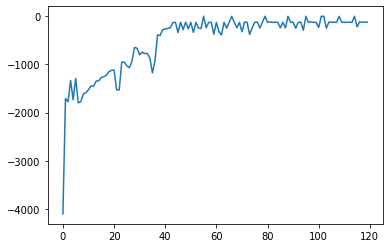

In [231]:
plt.plot(y, x)